In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import os
import lightgbm as lgb
import gc
import time
import datetime
from tqdm import tqdm_notebook as tqdm
import matplotlib.pylab as mpl 
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold as skfold
from sklearn.metrics import f1_score, accuracy_score
import math

pd.set_option('display.float_format', lambda x: '%.3f' % x)
#设置汉字格式
# sans-serif就是无衬线字体，是一种通用字体族。
# 常见的无衬线字体有 Trebuchet MS, Tahoma, Verdana, Arial, Helvetica,SimHei 中文的幼圆、隶书等等
mpl.rcParams['font.sans-serif'] = ['FangSong']  # 指定默认字体
%matplotlib inline

In [2]:
# 批量处理文件
train_path = './hy_round1_train_20200102/'
dirs = os.listdir(train_path)

In [16]:
data_list = []
for f in dirs:
    data_list.append(pd.read_csv(os.path.join(train_path,f)))

In [17]:
df = pd.concat(data_list, axis=0, ignore_index=True)

In [6]:
df.head()

,渔船ID,x,y,速度,方向,time,type
0,0,6152038.425,5124873.383,2.590,102,1110 11:58:19,拖网
1,0,6151229.510,5125218.015,2.700,113,1110 11:48:19,拖网
2,0,6150420.638,5125562.715,2.700,116,1110 11:38:19,拖网
3,0,6149611.808,5125907.483,3.290,95,1110 11:28:19,拖网
4,0,6148803.020,5126252.318,3.180,108,1110 11:18:19,拖网


In [6]:
df['type'].unique()

array(['拖网', '围网', '刺网'], dtype=object)

In [7]:
tmp = df[['速度','type']].groupby(by='type', as_index=False)['速度'].agg({'speed_avg':lambda x: np.mean(x),
                                                                     'speed_min':min ,
                                                                     'speed_max':max,
                                                                     'speed_median':np.median})

In [8]:
tmp

,type,speed_avg,speed_min,speed_max,speed_median
0,刺网,0.689,0.000,70.640,0.220
1,围网,1.824,0.000,93.150,0.320
2,拖网,2.025,0.000,100.160,0.320


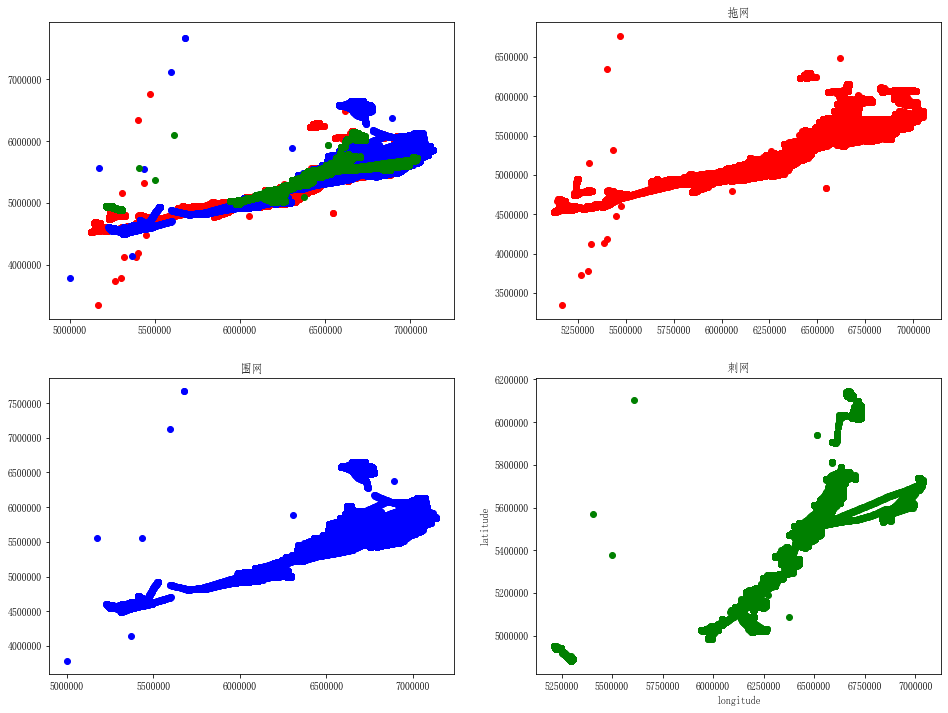

In [9]:
fig = plt.figure(figsize=(16,12))
plt.subplot(221)
plt.scatter(df[df['type'] == '拖网']['x'], df[df['type'] == '拖网']['y'], c='r')
plt.scatter(df[df['type'] == '围网']['x'], df[df['type'] == '围网']['y'], c='b')
plt.scatter(df[df['type'] == '刺网']['x'], df[df['type'] == '刺网']['y'], c='g')
plt.subplot(222)
plt.title('拖网')
plt.scatter(df[df['type'] == '拖网']['x'], df[df['type'] == '拖网']['y'], c='r')
plt.subplot(223)
plt.title('围网')
plt.scatter(df[df['type'] == '围网']['x'], df[df['type'] == '围网']['y'], c='b')
plt.subplot(224)
plt.title('刺网')
plt.scatter(df[df['type'] == '刺网']['x'], df[df['type'] == '刺网']['y'], c='g')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.show()

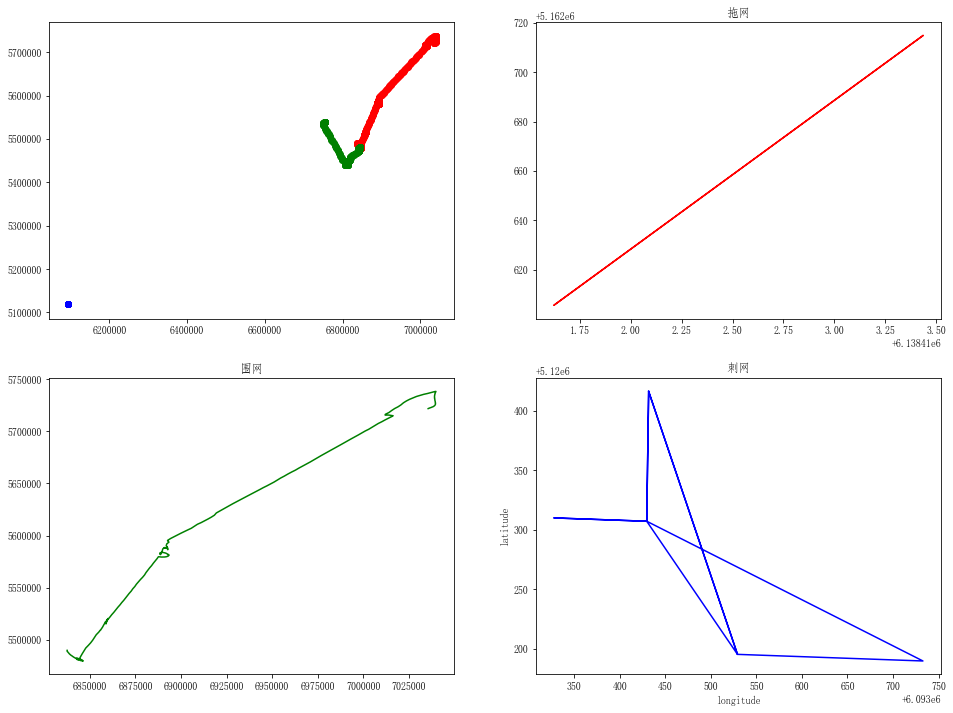

In [10]:
fig = plt.figure(figsize=(16,12))
plt.subplot(221)
plt.scatter(df[df['渔船ID'] == 990]['x'], df[df['渔船ID'] == 990]['y'], c='r')
plt.scatter(df[df['渔船ID'] == 1000]['x'], df[df['渔船ID'] == 1000]['y'], c='g')
plt.scatter(df[df['渔船ID'] == 997]['x'], df[df['渔船ID'] == 997]['y'], c='b')
plt.subplot(222)
plt.title('拖网')
plt.plot(df[df['渔船ID'] == 999]['x'], df[df['渔船ID'] == 999]['y'], c='r')
plt.subplot(223)
plt.title('围网')
plt.plot(df[df['渔船ID'] == 990]['x'], df[df['渔船ID'] == 990]['y'], c='g')
plt.subplot(224)
plt.title('刺网')
plt.plot(df[df['渔船ID'] == 997]['x'], df[df['渔船ID'] == 997]['y'], c='b')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.show()

In [11]:
# 统计每种数据与方向的关系
tmp = df[['方向','type']].groupby(by='type',as_index=False)['方向'].agg({'direction_avg':np.mean, 
                                                                   'direction_max':max, 
                                                                   'direction_min':min,
                                                                  'direction_median':np.median})
tmp

,type,direction_avg,direction_max,direction_min,direction_median
0,刺网,105.233,360,0,61
1,围网,124.027,360,0,101
2,拖网,114.158,360,0,81


In [12]:
tmp1 = df[df['type'] == '拖网'].groupby(by=['渔船ID', 'type'], as_index=False)['type'].agg({'type_count': lambda x: x.count()})
tmp2 = df[df['type'] == '围网'].groupby(by=['渔船ID', 'type'], as_index=False)['type'].agg({'type_count': lambda x: x.count()})
tmp3 = df[df['type'] == '刺网'].groupby(by=['渔船ID', 'type'], as_index=False)['type'].agg({'type_count': lambda x: x.count()})

In [13]:
tmp1 = tmp1.rename(columns={'type_count':'拖网次数'})
tmp2 = tmp2.rename(columns={'type_count':'围网次数'})
tmp3 = tmp3.rename(columns={'type_count':'刺网次数'})

In [14]:
unique_df = df[['渔船ID','type']].drop_duplicates().reset_index(drop=True)

In [15]:
unique_df = unique_df.merge(tmp1, on=['渔船ID','type'], how='left')

In [16]:
unique_df = unique_df.merge(tmp2, on=['渔船ID','type'], how='left')
unique_df = unique_df.merge(tmp3, on=['渔船ID','type'], how='left')

In [17]:
unique_df = unique_df.fillna(0)

In [18]:
unique_df1 = unique_df.groupby(by='渔船ID', as_index=False).agg({'拖网次数':sum, '围网次数':sum, '刺网次数':sum})

In [22]:
unique_df.head()

,渔船ID,type,拖网次数,围网次数,刺网次数
0,0,拖网,414.000,0.000,0.000
1,1,拖网,385.000,0.000,0.000
2,10,拖网,397.000,0.000,0.000
3,100,拖网,411.000,0.000,0.000
4,1000,围网,0.000,377.000,0.000


In [10]:
# 处理time
tmp_time = df.copy()

In [11]:
tmp_time['month'] = tmp_time['time'].apply(lambda x: time.strptime(x, '%m%d %H:%M:%S').tm_mon)
tmp_time['day'] = tmp_time['time'].apply(lambda x: time.strptime(x, '%m%d %H:%M:%S').tm_mday)
tmp_time['hour'] = tmp_time['time'].apply(lambda x: time.strptime(x, '%m%d %H:%M:%S').tm_hour)
tmp_time['minute'] = tmp_time['time'].apply(lambda x: time.strptime(x, '%m%d %H:%M:%S').tm_min)
tmp_time['second'] = tmp_time['time'].apply(lambda x: time.strptime(x, '%m%d %H:%M:%S').tm_sec)

In [26]:
cols = ['x', 'y', '方向', '速度']

In [27]:
tmp_time[['x_shift', 'y_shift', '方向_shift','速度_shift']] = tmp_time.groupby(by=['渔船ID', 'day'], as_index=False)['x','y', '方向', '速度'].shift(periods=-1)

In [69]:
tmp_time[tmp_time['渔船ID'] == 1001]

,渔船ID,x,y,速度,方向,time,type,month,day,hour,minute,second,x_shift,y_shift,方向_shift,速度_shift
1984,1001,6246424.331,5241152.582,0.320,279,1117 11:53:50,拖网,11,17,11,53,50,6246424.331,5241152.582,144.000,0.320
1985,1001,6246424.331,5241152.582,0.320,144,1117 11:43:48,拖网,11,17,11,43,48,6246424.331,5241152.582,0.000,0.110
1986,1001,6246424.331,5241152.582,0.110,0,1117 11:33:49,拖网,11,17,11,33,49,6246323.396,5241153.829,275.000,0.000
1987,1001,6246323.396,5241153.829,0.000,275,1117 11:23:46,拖网,11,17,11,23,46,6246323.396,5241153.829,0.000,0.000
1988,1001,6246323.396,5241153.829,0.000,0,1117 11:13:50,拖网,11,17,11,13,50,6246423.327,5241043.158,162.000,0.320
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2397,1001,6274752.740,5235808.806,2.700,10,1114 12:56:55,拖网,11,14,12,56,55,6274141.402,5235048.741,30.000,2.810
2398,1001,6274141.402,5235048.741,2.810,30,1114 12:47:11,拖网,11,14,12,47,11,6273731.983,5234286.781,20.000,3.020
2399,1001,6273731.983,5234286.781,3.020,20,1114 12:36:51,拖网,11,14,12,36,51,6273321.736,5233415.452,348.000,2.910
2400,1001,6273321.736,5233415.452,2.910,348,1114 12:26:38,拖网,11,14,12,26,38,6272499.513,5231454.117,10.000,3.400


In [67]:
tmp_time = tmp_time.apply(lambda x: fill_value(x), axis=1)

In [29]:
print('min month:{}'.format(tmp_time['month'].min()))
print('max month:{}'.format(tmp_time['month'].max()))
print('min day:{}'.format(tmp_time['day'].min()))
print('max day:{}'.format(tmp_time['day'].max()))
print('min hour:{}'.format(tmp_time['hour'].min()))
print('max hour:{}'.format(tmp_time['hour'].max()))

min month:10
max month:11
min day:1
max day:31
min hour:0
max hour:23


#  时间维度信息

1、间隔时间

2、不同间隔时间航行距离差

3、不同间隔时间航行速度差

4、方向差(可能没有卵用)

5、轨迹变化

6、距离

In [8]:
def get_distance(df):
    return np.sqrt((df['x']-df['x_shift'])**2 + (df['y'] - df['y_shift'])**2)

In [9]:
def fill_value(df):
    col = ['x', 'y', '方向','速度','month', 'day','hour','minute']
    for i in col:
        if math.isnan(df[i + '_shift']) == True:
            df[i + '_shift'] = df[i] 
    return df

In [ ]:
def average(df):
    a = df.sum()
    return a/(a+1)

In [55]:
# feature engineering
def get_feature(data):
    
    # 速度   
    print('=============================start to process speed======================================')
    start_time = time.time()
    tmp_df = data[['渔船ID', '速度']].groupby(by=['渔船ID'], as_index=False)['速度'].agg({'speed_avg':lambda x: np.mean(x),
                                                                     'speed_min':min ,
                                                                     'speed_max':max,
                                                                     'speed_median':np.median}).reset_index(drop=True)
    print
#     data = data.merge(tmp, on=['渔船ID'], how='left')    
#     print(data.columns)
    # 方向
    tmp = df[['渔船ID', '方向']].groupby(by='渔船ID', as_index=False)['方向'].agg({'direction_avg':lambda x: np.mean(x),
                                                                                 'direction_min':min ,
                                                                                 'direction_max':max,
                                                                                 'direction_median':np.median},).reset_index(drop=True)
    tmp_df = tmp_df.merge(tmp, on=['渔船ID'], how='left')    
    print('runtime:{}'.format(time.time()-start_time))
    
    # 经纬度
    print('=============================start to process lng、lat======================================')
    start_time = time.time()
    tmp = data[['渔船ID','x']].groupby(by='渔船ID', as_index=False)['x'].agg(
        {'x_avg':np.mean, 'x_min':min, 'x_max':max, 'x_median':np.median}).reset_index(drop=True)
        
    tmp_df = tmp_df.merge(tmp, on=['渔船ID'], how='left')
    
    tmp = data[['渔船ID','y']].groupby(by='渔船ID', as_index=False)['y'].agg(
        {'y_avg':np.mean, 'y_min':min, 'y_max':max, 'y_median':np.median}).reset_index(drop=True)
    
    tmp_df = tmp_df.merge(tmp, on=['渔船ID'], how='left')
    # 计算活动区域
    tmp_df['width'] = tmp_df['x_max'] - tmp_df['x_min']
    tmp_df['height'] = tmp_df['y_max'] - tmp_df['y_min']
    tmp_df['area'] = tmp_df['width'] * tmp_df['height']
    print('runtime:{}'.format(time.time()-start_time))

    print('=============================start to process datetime======================================')
#     start_time = time.time()
#     # 处理时间信息
#     data['month'] = data['time'].apply(lambda x: time.strptime(x, '%m%d %H:%M:%S').tm_mon)
#     data['day'] = data['time'].apply(lambda x: time.strptime(x, '%m%d %H:%M:%S').tm_mday)
#     data['hour'] = data['time'].apply(lambda x: time.strptime(x, '%m%d %H:%M:%S').tm_hour)
#     data['minute'] = data['time'].apply(lambda x: time.strptime(x, '%m%d %H:%M:%S').tm_min)
#     data['second'] = data['time'].apply(lambda x: time.strptime(x, '%m%d %H:%M:%S').tm_sec)    
#     print('runtime:{}'.format(time.time()-start_time))

    # 处理经纬度、速度方向变化,偏移值后第一列以初始数据填充
    print('=============================start to process shift data======================================')
#     start_time = time.time()
#     lines = ['x', 'y', '方向','速度','month', 'day','hour','minute']
#     shift_lines = [str(x)+'_shift' for x in lines]
#     data[shift_lines] = data.groupby(by=['渔船ID'], as_index=False)[lines].shift(periods=-1)
    
#     data = data.apply(lambda x:fill_value(x), axis=1)    
#     data['distance'] = data.apply(lambda x:get_distance(x), axis=1)
#     data['speed_diff'] = data['速度'] - data['速度_shift']
#     data['direction_diff'] = data['方向'] - data['方向_shift']
    
#     data['time_diff'] = (data['month'] - data['month_shift'])*31*24*60+(data['day'] - data['day_shift'])*24*60\
#                         + (data['hour']-data['hour_shift'])*60+(data['minute']-data['minute_shift'])
    
    print('runtime:{}'.format(time.time()-start_time))

    del tmp
    gc.collect()
    return tmp_df

In [25]:
data = get_feature(df)

=============================start to process speed======================================
runtime:1.9735538959503174
=============================start to process lng、lat======================================
runtime:0.322293758392334
=============================start to process datetime======================================
=============================start to process shift data======================================
runtime:0.32329463958740234


In [26]:
data.head()

,渔船ID,type,speed_avg,speed_min,speed_max,speed_median,direction_avg,direction_min,direction_max,direction_median,...,x_min,x_max,x_median,y_avg,y_min,y_max,y_median,width,height,area
0,0,拖网,0.266,0.000,9.390,0.000,4.614,0,129,0.000,...,6118351.758,6152038.425,6118351.758,5130494.116,5124873.383,5130781.358,5130672.326,33686.667,5907.976,199020006.769
1,1,拖网,1.608,0.000,10.470,0.050,56.153,0,336,0.000,...,6049471.868,6102449.881,6102449.881,5094050.266,5042857.339,5112873.995,5112759.651,52978.013,70016.656,3709343327.529
2,2,拖网,0.595,0.000,50.460,0.220,123.356,0,360,71.000,...,6182482.188,6183191.023,6183089.761,5193682.049,5193575.537,5193696.102,5193684.797,708.835,120.565,85460.709
3,3,拖网,1.471,0.000,10.090,0.220,121.134,0,352,91.000,...,5228590.204,5287804.942,5229842.637,4601532.486,4577467.435,4608628.097,4608404.322,59214.739,31160.661,1845170405.824
4,4,围网,1.412,0.000,10.090,0.320,139.067,0,359,112.000,...,7049394.099,7070796.583,7061678.845,6116389.445,6094995.864,6136032.747,6116620.836,21402.485,41036.883,878291256.598


# 建模
单模lightGBM

In [3]:
data.to_csv('feature_data.csv')

NameError: name 'data' is not defined

In [15]:
data = pd.read_csv('./feature_data.csv', index_col=0)

D:\Program Files (x86)\Anaconda\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [10]:
type_dict = {'拖网':0, '围网':1, '刺网':2}
data['type'] = data['type'].map(type_dict)

In [27]:
labels = data['type']

In [33]:
data = data.rename(columns={'渔船ID':'shipID'})

In [34]:
kf = skfold(n_splits=5, shuffle=True, random_state=2019)
# data = data.drop(columns='type')

In [88]:
cols = data.columns.tolist()

In [90]:
data.set_index(keys='shipID', inplace=True)

In [92]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7000 entries, 0 to 6999
Data columns (total 19 columns):
speed_avg           7000 non-null float64
speed_min           7000 non-null float64
speed_max           7000 non-null float64
speed_median        7000 non-null float64
direction_avg       7000 non-null float64
direction_min       7000 non-null int64
direction_max       7000 non-null int64
direction_median    7000 non-null float64
x_avg               7000 non-null float64
x_min               7000 non-null float64
x_max               7000 non-null float64
x_median            7000 non-null float64
y_avg               7000 non-null float64
y_min               7000 non-null float64
y_max               7000 non-null float64
y_median            7000 non-null float64
width               7000 non-null float64
height              7000 non-null float64
area                7000 non-null float64
dtypes: float64(17), int64(2)
memory usage: 1.1 MB


In [93]:
scores = []
f1_scores = []
best = 0
i=0
models = []
best_f = -1

clf = lgb.LGBMClassifier(
    learning_rate=0.01,
    n_estimators=20000,
    num_leaves= 15,
    max_depth = -1,
    subsample=0.9,
    colsample_bytree=0.8,
    random_state=2019,
    n_jobs=4
) 


for train, test in kf.split(data,labels):
#     train_data = lgb.Dataset(data.iloc[train])
#     test_data = lgb.Dataset(data.iloc[test])
    model=clf.fit(      
            data.iloc[train],
            labels[train],
            eval_set=[(data.iloc[test],labels[test])],
            early_stopping_rounds=500,
            eval_metric='multiclass',
            verbose=50)
    
    models.append(model)
    label_pre = clf.predict(data.iloc[test])
    score = accuracy_score(labels[test], label_pre)
    f1 = f1_score(labels[test], label_pre, average='macro')
    
    # 保存f1分数结果最好的值
    if f1 > best_f:
        best = i  
        best_f  = f1
        best_model = model
    
    print('score:{}'.format(score))
    print('f1_score{}'.format(f1))
    scores.append(score)   
    f1_scores.append(f1)
    i += 1

Training until validation scores don't improve for 500 rounds
[50]	valid_0's multi_logloss: 0.676618
[100]	valid_0's multi_logloss: 0.559921
[150]	valid_0's multi_logloss: 0.493343
[200]	valid_0's multi_logloss: 0.449594
[250]	valid_0's multi_logloss: 0.41936
[300]	valid_0's multi_logloss: 0.398663
[350]	valid_0's multi_logloss: 0.382951
[400]	valid_0's multi_logloss: 0.370006
[450]	valid_0's multi_logloss: 0.360161
[500]	valid_0's multi_logloss: 0.351426
[550]	valid_0's multi_logloss: 0.344035
[600]	valid_0's multi_logloss: 0.337949
[650]	valid_0's multi_logloss: 0.333344
[700]	valid_0's multi_logloss: 0.328145
[750]	valid_0's multi_logloss: 0.323833
[800]	valid_0's multi_logloss: 0.32034
[850]	valid_0's multi_logloss: 0.317502
[900]	valid_0's multi_logloss: 0.314413
[950]	valid_0's multi_logloss: 0.311902
[1000]	valid_0's multi_logloss: 0.309261
[1050]	valid_0's multi_logloss: 0.306785
[1100]	valid_0's multi_logloss: 0.304569
[1150]	valid_0's multi_logloss: 0.302636
[1200]	valid_0's 

[2500]	valid_0's multi_logloss: 0.245008
[2550]	valid_0's multi_logloss: 0.244494
[2600]	valid_0's multi_logloss: 0.244157
[2650]	valid_0's multi_logloss: 0.243965
[2700]	valid_0's multi_logloss: 0.24345
[2750]	valid_0's multi_logloss: 0.242901
[2800]	valid_0's multi_logloss: 0.24225
[2850]	valid_0's multi_logloss: 0.241869
[2900]	valid_0's multi_logloss: 0.241652
[2950]	valid_0's multi_logloss: 0.241221
[3000]	valid_0's multi_logloss: 0.240856
[3050]	valid_0's multi_logloss: 0.240612
[3100]	valid_0's multi_logloss: 0.24037
[3150]	valid_0's multi_logloss: 0.240217
[3200]	valid_0's multi_logloss: 0.240064
[3250]	valid_0's multi_logloss: 0.239859
[3300]	valid_0's multi_logloss: 0.239646
[3350]	valid_0's multi_logloss: 0.239625
[3400]	valid_0's multi_logloss: 0.239371
[3450]	valid_0's multi_logloss: 0.238982
[3500]	valid_0's multi_logloss: 0.238797
[3550]	valid_0's multi_logloss: 0.238886
[3600]	valid_0's multi_logloss: 0.238925
[3650]	valid_0's multi_logloss: 0.238678
[3700]	valid_0's mu

[2700]	valid_0's multi_logloss: 0.243291
[2750]	valid_0's multi_logloss: 0.242672
[2800]	valid_0's multi_logloss: 0.242396
[2850]	valid_0's multi_logloss: 0.24186
[2900]	valid_0's multi_logloss: 0.241069
[2950]	valid_0's multi_logloss: 0.240117
[3000]	valid_0's multi_logloss: 0.239579
[3050]	valid_0's multi_logloss: 0.239155
[3100]	valid_0's multi_logloss: 0.238751
[3150]	valid_0's multi_logloss: 0.238396
[3200]	valid_0's multi_logloss: 0.237911
[3250]	valid_0's multi_logloss: 0.237229
[3300]	valid_0's multi_logloss: 0.236832
[3350]	valid_0's multi_logloss: 0.236592
[3400]	valid_0's multi_logloss: 0.236351
[3450]	valid_0's multi_logloss: 0.236087
[3500]	valid_0's multi_logloss: 0.235739
[3550]	valid_0's multi_logloss: 0.235296
[3600]	valid_0's multi_logloss: 0.235094
[3650]	valid_0's multi_logloss: 0.234915
[3700]	valid_0's multi_logloss: 0.234626
[3750]	valid_0's multi_logloss: 0.234384
[3800]	valid_0's multi_logloss: 0.234239
[3850]	valid_0's multi_logloss: 0.234121
[3900]	valid_0's 

In [94]:
print('besf f1:{}.'.format(best_f))
print('mean f1:{}'.format(np.mean(f1_scores)))
print('mean scores:{}'.format(np.mean(scores)))

besf f1:0.8855039680618896.
mean f1:0.8799335450067888
mean scores:0.9065714285714286


In [95]:
f1_scores

[0.871529124247764,
 0.8773452089529626,
 0.8855039680618896,
 0.8813620711086149,
 0.8839273526627128]

In [47]:
test_path  = './hy_round1_testA_20200102/'
test_dir = os.listdir(test_path)

In [51]:
test_list = []
for f in test_dir:
    test = pd.read_csv(os.path.join(test_path,f))
    test_list.append(test)

test_df = pd.concat(test_list, ignore_index= True)

In [56]:
test_data = get_feature(test_df)

=============================start to process speed======================================
runtime:1.1220216751098633
=============================start to process lng、lat======================================
runtime:0.1110994815826416
=============================start to process datetime======================================
=============================start to process shift data======================================
runtime:0.1110994815826416


In [97]:
test_data = test_data.rename(columns={'渔船ID':'shipID'})
test_data.set_index(keys='shipID', inplace=True)

In [99]:
y = best_model.predict(test_data)

In [67]:
f = dict((test_data['shipID'], y))

In [69]:
sub = pd.DataFrame([f])

In [75]:
sub = sub.T

In [78]:
sub.to_csv('baseline.csv', encoding='utf-8-sig', header=False, sep=',')

In [100]:
scores = best_model.feature_importances_

In [101]:
import_feature = dict(zip(test_data.columns.values, scores))

In [102]:
import_feature

{'speed_avg': 10982,
 'speed_min': 1505,
 'speed_max': 8943,
 'speed_median': 9449,
 'direction_avg': 12444,
 'direction_min': 774,
 'direction_max': 4763,
 'direction_median': 8556,
 'x_avg': 8646,
 'x_min': 12549,
 'x_max': 10084,
 'x_median': 13013,
 'y_avg': 8709,
 'y_min': 11188,
 'y_max': 13332,
 'y_median': 12333,
 'width': 10769,
 'height': 10249,
 'area': 9078}